In [ ]:
%%capture

!pip install imutils
!pip install opencv-python
!pip install seaborn
# !pip install opencv-python --prefer-binary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, Dropout, Conv2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras import regularizers
import tensorflow as tf


In [2]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import imutils
import random
import cv2
import os
import os
import cv2
import numpy as np
import pandas as pd


In [5]:

# def process_folder(folder_path):
#     data = []
#     for label in sorted(os.listdir(folder_path)):
#         if label in exclude_chars:
#             continue
#         label_path = os.path.join(folder_path, label)
#         if not os.path.isdir(label_path):
#             continue
#         for img_file in os.listdir(label_path):
#             img_path = os.path.join(label_path, img_file)
#             img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if img is None:
#                 continue
#             # Resize to 32x32
#             img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#             pixels = img_resized.flatten()
#             row = [label] + pixels.tolist()
#             data.append(row)
#     return data


# # Paths
# base_dir = 'handwritten-characters'
# train_dir = os.path.join(base_dir, 'Train')
# val_dir = os.path.join(base_dir, 'Validation')

# # Exclude these characters
# exclude_chars = {'#', '@', '&', '$'}

# # Desired image size
# IMG_SIZE = 32


# # Process and convert to DataFrame
# train_data = process_folder(train_dir)
# val_data = process_folder(val_dir)

# # Create column names
# columns = ['label'] + [f'pixel_{i}' for i in range(IMG_SIZE * IMG_SIZE)]

# # Save to CSV
# pd.DataFrame(train_data, columns=columns).to_csv('train_data.csv', index=False)
# pd.DataFrame(val_data, columns=columns).to_csv('val_data.csv', index=False)

# print(f"Saved resized training data to train_data.csv ({len(train_data)} samples)")
# print(f"Saved resized validation data to val_data.csv ({len(val_data)} samples)")


In [7]:
# def load_data_from_csv(csv_path):
#     df = pd.read_csv(csv_path)
#     labels = df['label'].values
#     pixel_columns = df.columns[1:]
#     images = df[pixel_columns].values.astype(np.uint8)
#     images = images.reshape((-1, IMG_SIZE, IMG_SIZE))  # (num_samples, 32, 32)
#     return images, labels

# # Example usage
# IMG_SIZE = 32

# train_images, train_labels = load_data_from_csv('train_data.csv')
# val_images, val_labels = load_data_from_csv('val_data.csv')

# print(f"Loaded {len(train_images)} train images (shape: {train_images[0].shape})")
# print(f"Loaded {len(val_images)} val images (shape: {val_images[0].shape})")


In [9]:
# cv2.imshow('Example Image', val_images[0])
# cv2.waitKey(0)

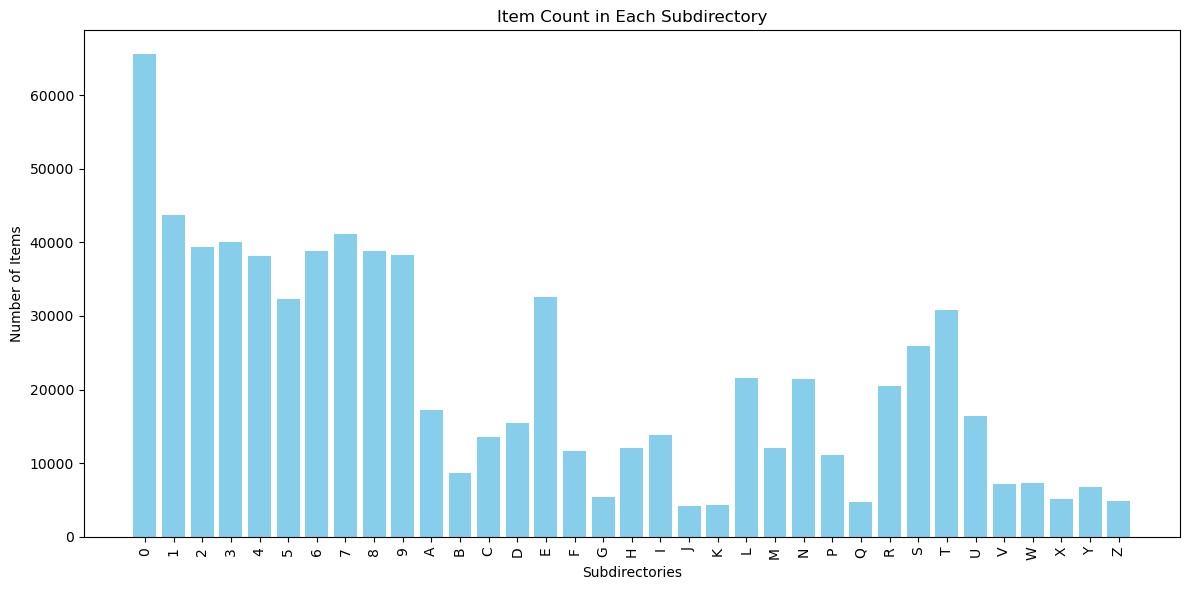

In [11]:
import os
import matplotlib.pyplot as plt

# Path to your main directory
dir = "./handwritten-characters/Train/"

# Data containers
labels = []
counts = []

non_chars = ["#","$","&","@"]

# Count items in each subdirectory
for i in os.listdir(dir):
    if i in non_chars:
        continue

    sub_directory = os.path.join(dir, i)
    
    if os.path.isdir(sub_directory):
        items = os.listdir(sub_directory)
        count = len(items)
        
        labels.append(i)
        counts.append(count)
        
        # print(f'Total items in directory {i} are: {count}')

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Subdirectories')
plt.ylabel('Number of Items')
plt.title('Item Count in Each Subdirectory')
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()


In [12]:
dir = "./handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 10000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [13]:
len(train_data)

308658

In [15]:
val_dir = "./handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [ ]:
len(val_data)

In [41]:
random.shuffle(train_data)
random.shuffle(val_data)

In [43]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [45]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [47]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [48]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [50]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [65]:
print("Dataset Shapes")
print("-" * 30)
print(f"Train X shape : {train_X.shape}")
print(f"Train Y shape : {train_Y.shape}")
print(f"Val   X shape : {val_X.shape}")
print(f"Val   Y shape : {val_Y.shape}")

Dataset Shapes
------------------------------
Train X shape : (308658, 32, 32, 1)
Train Y shape : (308658, 35)
Val   X shape : (15209, 32, 32, 1)
Val   Y shape : (15209, 35)


# Model

In [68]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Input(shape=(32, 32, 1)),
    
    # Block 1
    Conv2D(32, (3, 3), padding="same", activation='relu', 
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # Block 2
    Conv2D(64, (3, 3), padding="same", activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Block 3
    Conv2D(128, (3, 3), padding="same", activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(35, activation='softmax')
])

# Use a low learning rate to
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

# More patient callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

In [70]:
model.summary()
 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             

 Total params: 309,763 (1.18 MB)

 Trainable params: 308,611 (1.18 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [19]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import tensorflow as tf

# 4. Train the model

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    with tf.device('/GPU:0'):  # Use GPU if available
        history = model.fit(
            train_X, train_Y,
            epochs=20,  
            batch_size=32,
            validation_data=(val_X, val_Y),
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
else:
    print("No GPU found, using CPU instead")
    history = model.fit(
        train_X, train_Y,
        epochs=20,   
        batch_size=32,
        validation_data=(val_X, val_Y),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

Train on 308658 samples, validate on 15209 samples
Epoch 1/20
308658/308658 [==============================] - 112s 362us/sample - loss: 1.7232 - accuracy: 0.5770 - val_loss: 0.6315 - val_accuracy: 0.8752
Epoch 2/20
308658/308658 [==============================] - 100s 324us/sample - loss: 0.7131 - accuracy: 0.8303 - val_loss: 0.4835 - val_accuracy: 0.8984
Epoch 3/20
308658/308658 [==============================] - 98s 319us/sample - loss: 0.5403 - accuracy: 0.8687 - val_loss: 0.4181 - val_accuracy: 0.9094
Epoch 4/20
308658/308658 [==============================] - 98s 316us/sample - loss: 0.4563 - accuracy: 0.8855 - val_loss: 0.3583 - val_accuracy: 0.9144
Epoch 5/20
308658/308658 [==============================] - 107s 346us/sample - loss: 0.4066 - accuracy: 0.8941 - val_loss: 0.3318 - val_accuracy: 0.9199
Epoch 6/20
308658/308658 [==============================] - 105s 342us/sample - loss: 0.3728 - accuracy: 0.9002 - val_loss: 0.3047 - val_accuracy: 0.9213
Epoch 7/20
308658/308658 [=

``` Train on 308658 samples, validate on 15209 samples
Epoch 1/20
308658/308658 [==============================] - 112s 362us/sample - loss: 1.7232 - accuracy: 0.5770 - val_loss: 0.6315 - val_accuracy: 0.8752
Epoch 2/20
308658/308658 [==============================] - 100s 324us/sample - loss: 0.7131 - accuracy: 0.8303 - val_loss: 0.4835 - val_accuracy: 0.8984
Epoch 3/20
308658/308658 [==============================] - 98s 319us/sample - loss: 0.5403 - accuracy: 0.8687 - val_loss: 0.4181 - val_accuracy: 0.9094
Epoch 4/20
308658/308658 [==============================] - 98s 316us/sample - loss: 0.4563 - accuracy: 0.8855 - val_loss: 0.3583 - val_accuracy: 0.9144
Epoch 5/20
308658/308658 [==============================] - 107s 346us/sample - loss: 0.4066 - accuracy: 0.8941 - val_loss: 0.3318 - val_accuracy: 0.9199
Epoch 6/20
308658/308658 [==============================] - 105s 342us/sample - loss: 0.3728 - accuracy: 0.9002 - val_loss: 0.3047 - val_accuracy: 0.9213
Epoch 7/20
308658/308658 [==============================] - 97s 314us/sample - loss: 0.3487 - accuracy: 0.9052 - val_loss: 0.3091 - val_accuracy: 0.9180
Epoch 8/20
308658/308658 [==============================] - 112s 363us/sample - loss: 0.3344 - accuracy: 0.9079 - val_loss: 0.2942 - val_accuracy: 0.9253
Epoch 9/20
308658/308658 [==============================] - 120s 390us/sample - loss: 0.3210 - accuracy: 0.9103 - val_loss: 0.2677 - val_accuracy: 0.9233
Epoch 10/20
308658/308658 [==============================] - 120s 389us/sample - loss: 0.3119 - accuracy: 0.9124 - val_loss: 0.2593 - val_accuracy: 0.9346
Epoch 11/20
308658/308658 [==============================] - 116s 376us/sample - loss: 0.3033 - accuracy: 0.9139 - val_loss: 0.2617 - val_accuracy: 0.9233
Epoch 12/20
308658/308658 [==============================] - 111s 361us/sample - loss: 0.2968 - accuracy: 0.9159 - val_loss: 0.2505 - val_accuracy: 0.9303
Epoch 13/20
308658/308658 [==============================] - 110s 357us/sample - loss: 0.2926 - accuracy: 0.9162 - val_loss: 0.2679 - val_accuracy: 0.9236
Epoch 14/20
308658/308658 [==============================] - 110s 357us/sample - loss: 0.2892 - accuracy: 0.9171 - val_loss: 0.2760 - val_accuracy: 0.9222
Epoch 15/20
308658/308658 [==============================] - 108s 350us/sample - loss: 0.2847 - accuracy: 0.9189 - val_loss: 0.2454 - val_accuracy: 0.9356
Epoch 16/20
308658/308658 [==============================] - 112s 363us/sample - loss: 0.2821 - accuracy: 0.9189 - val_loss: 0.2481 - val_accuracy: 0.9336
Epoch 17/20
308658/308658 [==============================] - 110s 356us/sample - loss: 0.2811 - accuracy: 0.9195 - val_loss: 0.2429 - val_accuracy: 0.9371
Epoch 18/20
308658/308658 [==============================] - 110s 357us/sample - loss: 0.2785 - accuracy: 0.9204 - val_loss: 0.2469 - val_accuracy: 0.9309
Epoch 19/20
308658/308658 [==============================] - 110s 356us/sample - loss: 0.2752 - accuracy: 0.9210 - val_loss: 0.2445 - val_accuracy: 0.9287
Epoch 20/20
308658/308658 [==============================] - 116s 374us/sample - loss: 0.2733 - accuracy: 0.9217 - val_loss: 0.2501 - val_accuracy: 0.9298
```

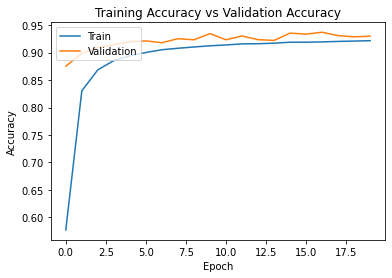

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

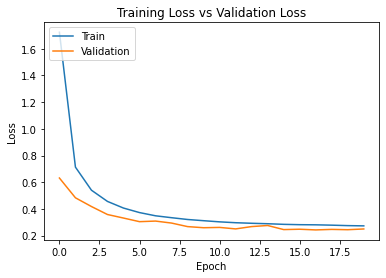

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Save Model

In [20]:
model.save("my_model.h5")


## Load Model

In [72]:
from tensorflow.keras.models import load_model
model.load_weights("./my_model.h5")

# model = load_model("./my_model.h5",safe_mode=False)


## test

In [75]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [77]:
def white_balance(img):
    result = img.astype(np.float32)
    avg_b = np.mean(result[:, :, 0])
    avg_g = np.mean(result[:, :, 1])
    avg_r = np.mean(result[:, :, 2])
    avg_gray = (avg_b + avg_g + avg_r) / 3
    result[:, :, 0] = np.minimum(result[:, :, 0] * (avg_gray / avg_b), 255)
    result[:, :, 1] = np.minimum(result[:, :, 1] * (avg_gray / avg_g), 255)
    result[:, :, 2] = np.minimum(result[:, :, 2] * (avg_gray / avg_r), 255)
    return result.astype(np.uint8)

In [81]:
def get_letters(img,source=None):
    letters = []
    if source == "cam":
        image = cv2.convertScaleAbs(img, alpha=2, beta=20)       # cam
        image = white_balance(image)          # cam
    else:
        image=img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [83]:
def get_word(letter):
    word = "".join(letter)
    return word

In [85]:
def put_text_on_image(image, word,  color=(255, 0, 0)):
    h, w = image.shape[:2]
    header_height = 50
    new_image = np.zeros((h + header_height, w, 3), dtype=np.uint8)
    new_image[:header_height] = (255, 255, 255)  # white header background
    new_image[header_height:] = image

    # Text parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    # Get text size
    (text_width, text_height), baseline = cv2.getTextSize(word, font, font_scale, font_thickness)

    # Calculate position to center text in header
    x = (w - text_width) // 2
    y = (header_height + text_height) // 2  # vertically centered in 50px

    # Draw the text
    cv2.putText(new_image, word, (x, y), font, font_scale, (255, 0, 0), font_thickness, lineType=cv2.LINE_AA)
    return new_image

In [97]:
try:
    cnt=0
    for i in range(1, 10):  # 1 to 10 inclusive
        filename = "./handwriting-recognition/train_v2/train/TRAIN_0003"+str(i)+".jpg"
        image = cv2.imread(filename)
        letter,image = get_letters(image)
        word = get_word(letter)
        img =  put_text_on_image(image, word,color=(255, 0, 0))
        cv2.imshow('Image with Text', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
except Exception as e:
    print(f"An error occurred: {e}")
    print("Make sure the image files exist in the specified path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

In [89]:
try:

    filename = "./handwriting-recognition/train_v2/train/TRAIN_00002.jpg"
    image = cv2.imread(filename)
    letter,image = get_letters(image)
    word = get_word(letter)
    img =  put_text_on_image(image, word,color=(255, 0, 0))
    cv2.imshow('Image with Text', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
except Exception as e:
    print(f"An error occurred: {e}")
    print("Make sure the image files exist in the specified path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
JAFFEUX


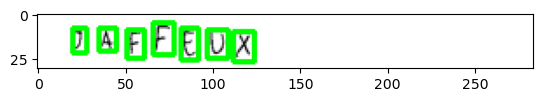

In [93]:
image = cv2.imread("./handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
letter,image = get_letters(image)

word = get_word(letter)
print(word)
plt.imshow(image)

In [107]:
import cv2

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open camera")
    exit()

try:
    while True:
        ret, image = cap.read()
        if not ret:
            print("Can't receive frame. Exiting...")
            break
        
        letter,image = get_letters(image,source="cam")
        word = get_word(letter)
        img =  put_text_on_image(image, word,color=(255, 0, 0))

        cv2.imshow("Processed Image", img)
    
        if cv2.waitKey(1000) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
